Import the libraries

In [1]:
import tensorflow.examples.tutorials.mnist.input_data as input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

/home/monica/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load the dataset

In [2]:
#mnist = fetch_mldata('MNIST original', data_home = 'home/monica/data/')
mnist=input_data.read_data_sets("MNIST")

global benchmark_cols
benchmark_cols = ['Variance retained','n_Components','Time(s)','Accuracy_percentage']
global benchmarking_data
benchmarking_data = pd.DataFrame(columns = benchmark_cols)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
train_data = mnist.train.images 
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
test_data = mnist.test.images
test_labels = np.asarray(mnist.test.labels, dtype = np.int32)

Preprocess data

In [4]:
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

Let’s collect the following benchmarking information:
<br>1) Variance: The variance of the original data that is retained
<br>2) N_components: number of principal components 
<br>3) Timing: time to fit  training
<br>4) Accuracy: Accuracy obtained
We will capture the above attributes from each experiment run.

Fit the model and collect the benchmarking metrics when all dimensions are used

In [5]:
variance = 1.0
n_components = train_data.shape[1]
model = LogisticRegression(solver = 'lbfgs')
start = time.time()
model.fit(train_data, train_labels)
end =  time.time()
timing = end-start

Validate the model fit

In [6]:
y_pred = model.predict(test_data)
count_misclassified = (test_labels != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(test_labels, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 826
Accuracy: 0.92


Print the benchmarking metrics

In [7]:
print(dict(zip(benchmark_cols,[variance,n_components,timing,accuracy])))
benchmarking_data = benchmarking_data.iloc[0:0]
benchmarking_data = benchmarking_data.append(dict(zip(benchmark_cols,[variance,n_components,timing,accuracy])),ignore_index=True)

{'Variance retained': 1.0, 'n_Components': 784, 'Time(s)': 48.936928272247314, 'Accuracy_percentage': 0.9174}


Decide on the variance percentages for which we would like to conduct experiments.

In [8]:
variance_list = [0.95,0.90,0.85,0.80,0.75,0.70]

Define a function to run the same model with various variances and run it

In [9]:
def benchmark_pca(variance,train_img,train_lbl,test_img,test_lbl):
    global benchmarking_data
    pca = PCA(variance)
    pca.fit(train_img)
    n_components = pca.n_components_
    train_img = pca.transform(train_img)

    # pca.fit(test_img)
    test_img = pca.transform(test_img)
    logisticRegr = LogisticRegression(solver = 'lbfgs')
    start = time.time()
    logisticRegr.fit(train_img, train_lbl)
    end =  time.time()
    
    timing = end-start
    
    # Predict for Multiple Observations (images) at Once
    predicted = logisticRegr.predict(test_img)
    
    # generate evaluation metrics
    accuracy = (metrics.accuracy_score(test_lbl, predicted))
    #return 
    vals = dict(zip(benchmark_cols,[variance,n_components,timing,accuracy]))
    benchmarking_data = benchmarking_data.append(vals,ignore_index=True)
    

for variance in variance_list:
    benchmark_pca(variance,train_data,train_labels,test_data,test_labels)

In [10]:
print(benchmarking_data)

   Variance retained  n_Components    Time(s)  Accuracy_percentage
0               1.00         784.0  48.936928               0.9174
1               0.95         330.0  26.438228               0.9215
2               0.90         236.0  18.421920               0.9185
3               0.85         185.0  15.343364               0.9169
4               0.80         148.0  12.913184               0.9142
5               0.75         120.0  11.310373               0.9135
6               0.70          98.0  10.191293               0.9093


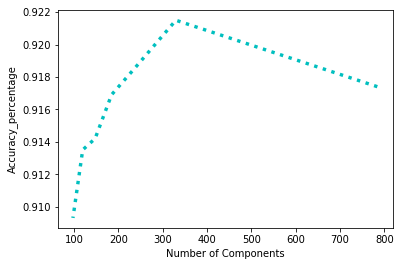

In [11]:
plt.plot(benchmarking_data['n_Components'], benchmarking_data['Accuracy_percentage'],color = 'c', ls = 'dotted', lw = 3.4)
plt.xlabel("Number of Components")
plt.ylabel("Accuracy_percentage")
plt.show()


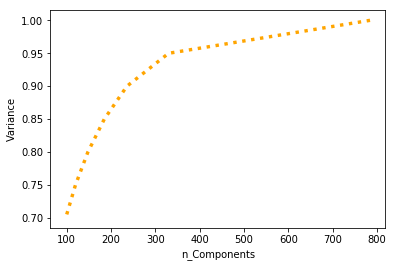

In [14]:
plt.plot(benchmarking_data['n_Components'], benchmarking_data['Variance retained'], color = 'orange', ls = 'dotted', lw = 3.4)
plt.xlabel("n_Components")
plt.ylabel("Variance")
plt.show()

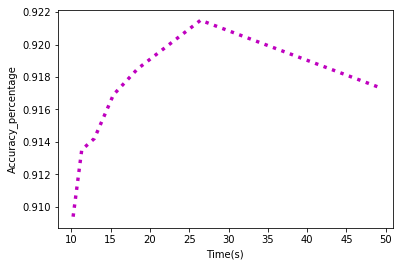

In [15]:
plt.plot(benchmarking_data['Time(s)'], benchmarking_data['Accuracy_percentage'],color = 'm', ls = 'dotted', lw = 3.4)
plt.xlabel('Time(s)')
plt.ylabel('Accuracy_percentage')
plt.show()